### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3.08
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
#!pip install matplotlib-label-lines
import pandas
print(pandas.__version__)
#!pip install --upgrade pandas

1.3.5


In [2]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result\\3.08"
numberOfGenerations = 150;
percolation = 0.63;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

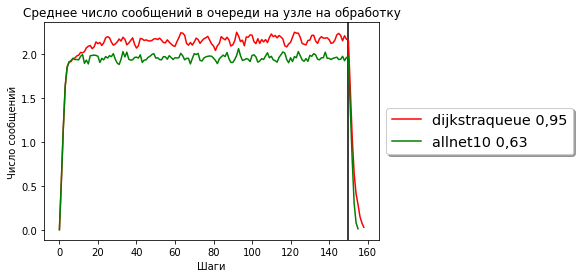

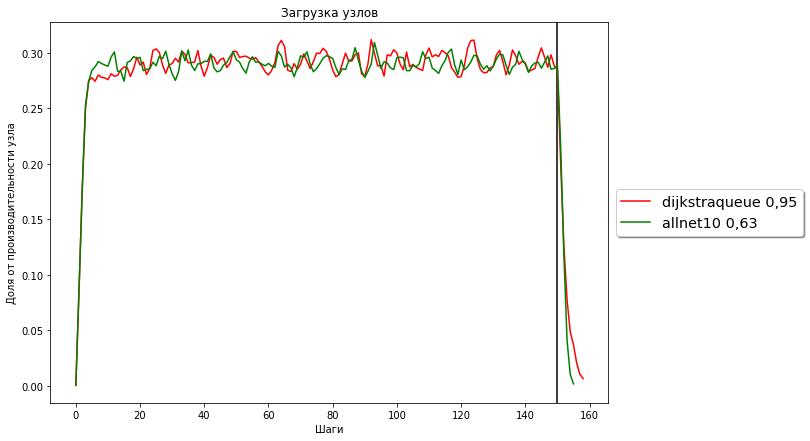

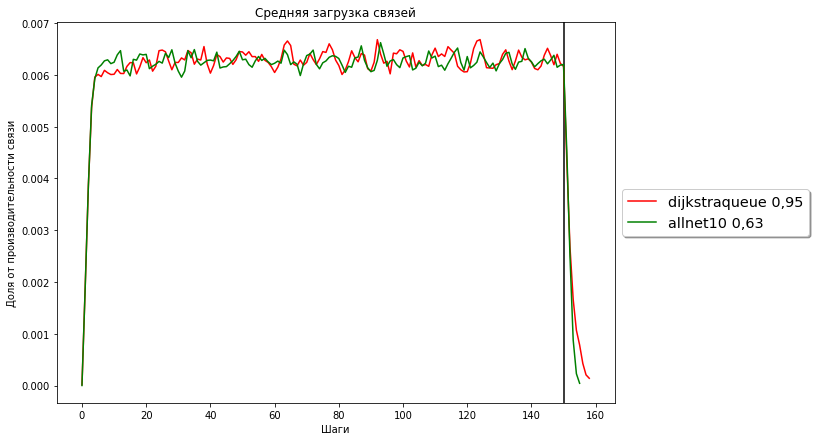

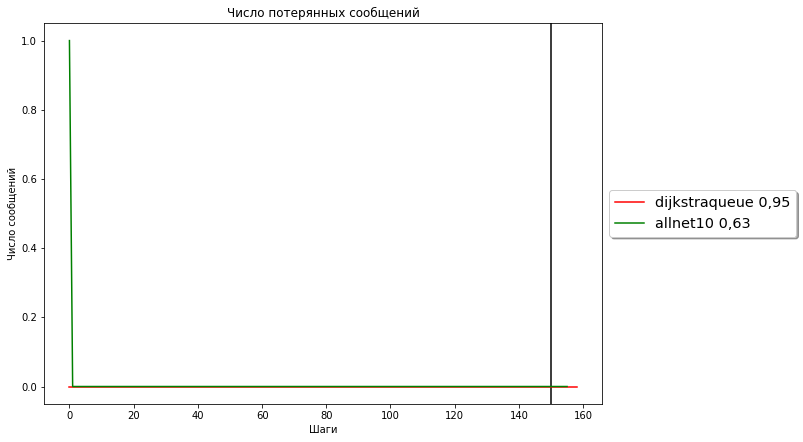

Доставлено 15001 Потеряно 0.0000% -dijkstraqueue 0,95
Доставлено 15000 Потеряно 0.0067% -allnet10 0,63


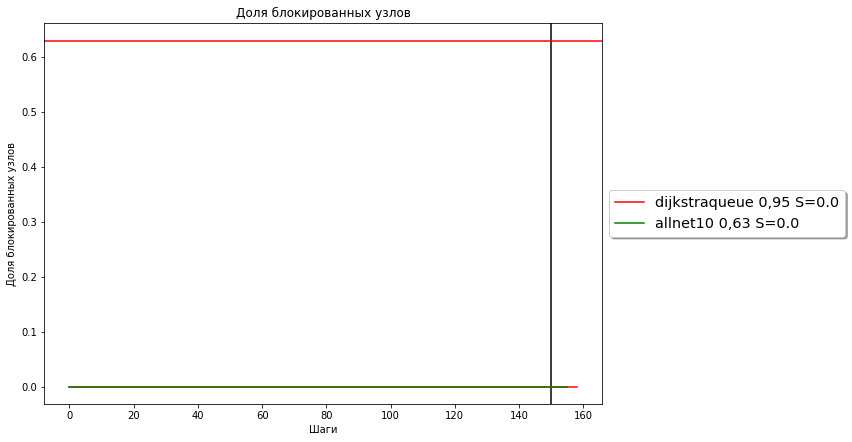

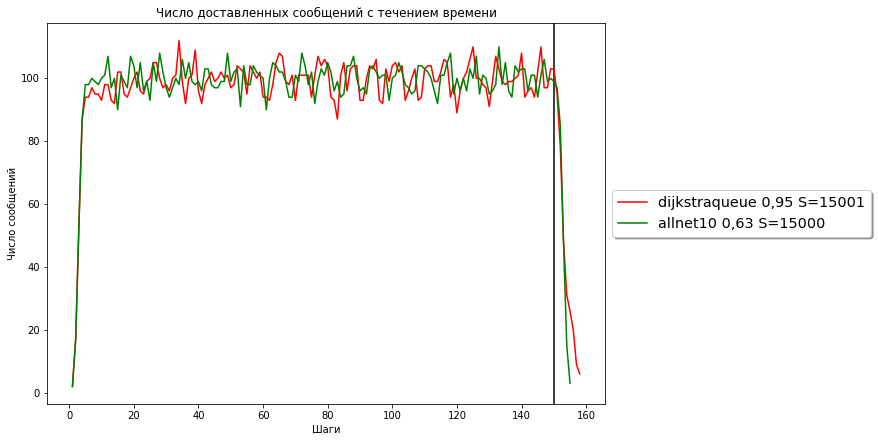

In [3]:
quantity = 100;
log_tags = [
{"tag":  "4e6aa49c-cd2f-45f2-9c6f-8f3af3b87a9d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "679cc555-66e0-44c3-86e7-648f78da8063", "label": "allnet10 0,63", "color": "green"},
]
showStat()
showStatBlocked();
showStatMessage();



<strong>Quantity 500 </strong>

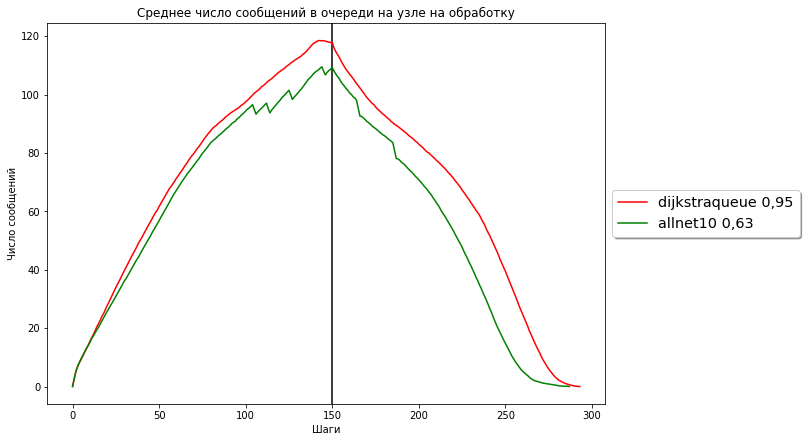

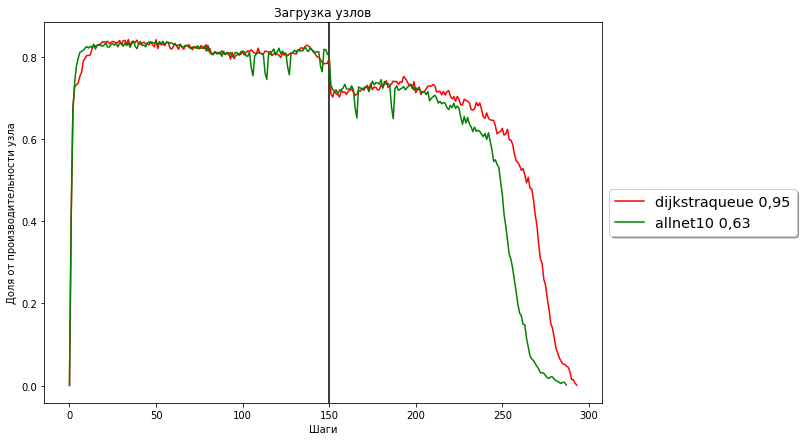

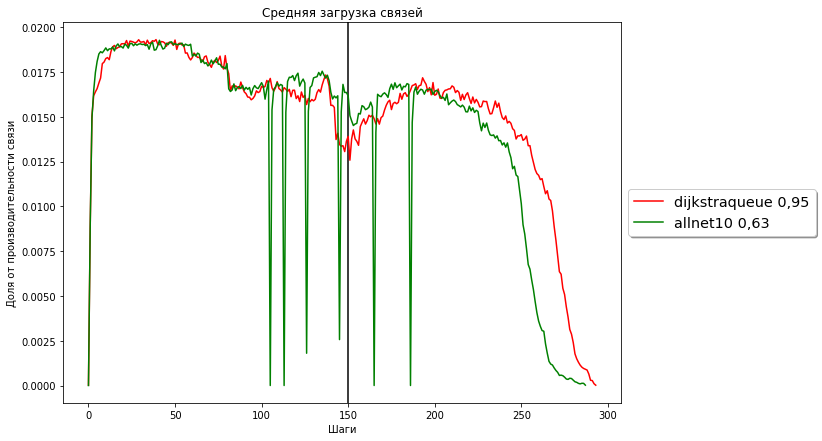

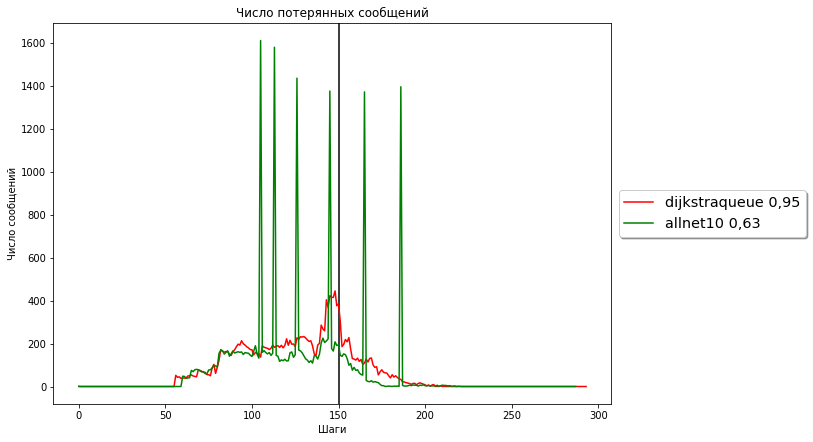

Доставлено 54377 Потеряно 27.4983% -dijkstraqueue 0,95
Доставлено 52764 Потеряно 29.6489% -allnet10 0,63


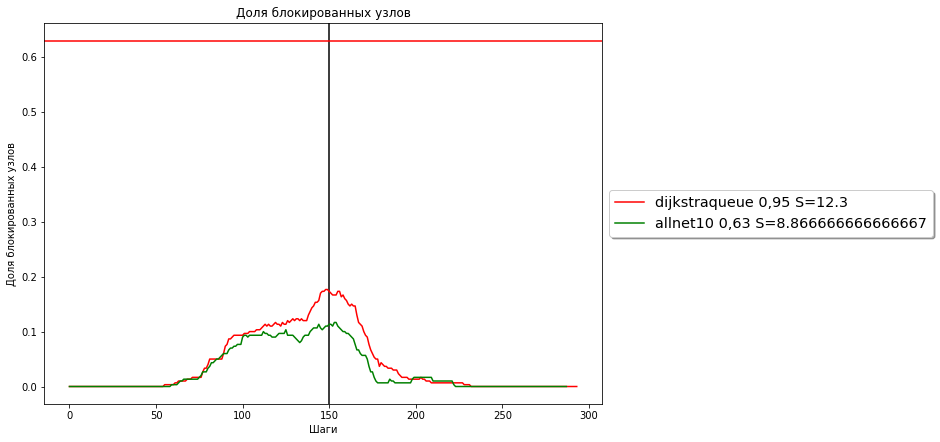

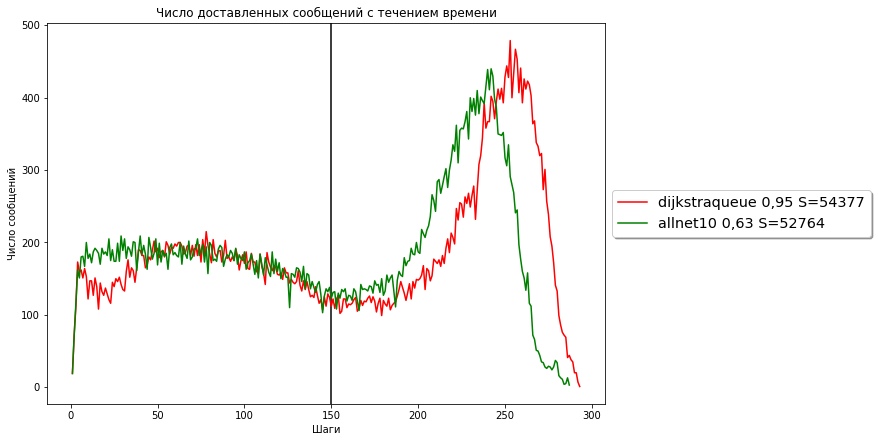

In [4]:

quantity = 500;
log_tags = [
{"tag":  "e753544f-0d05-4e7e-bb06-9a5073623934", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "169fe1fd-1f8e-4621-afba-92c10cf91ff1", "label": "allnet10 0,63", "color": "green"},
]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

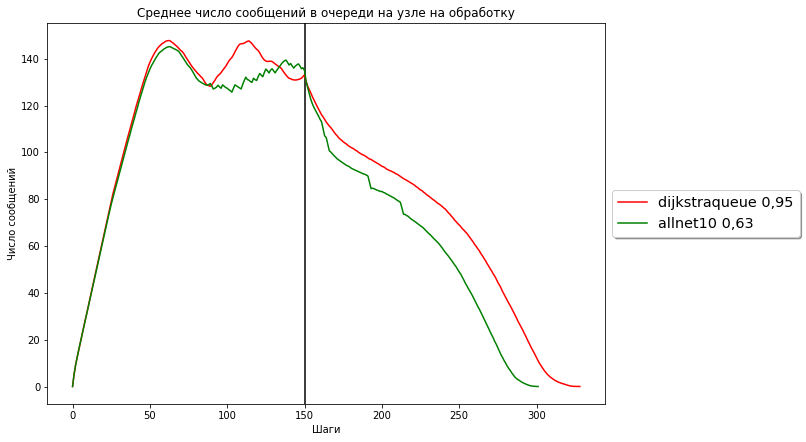

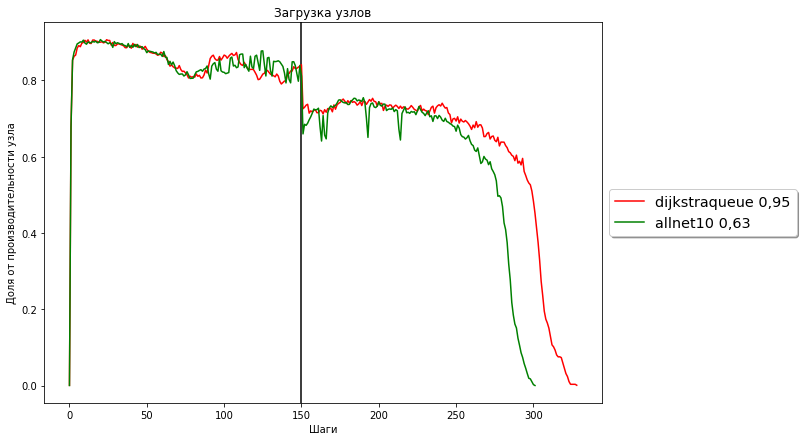

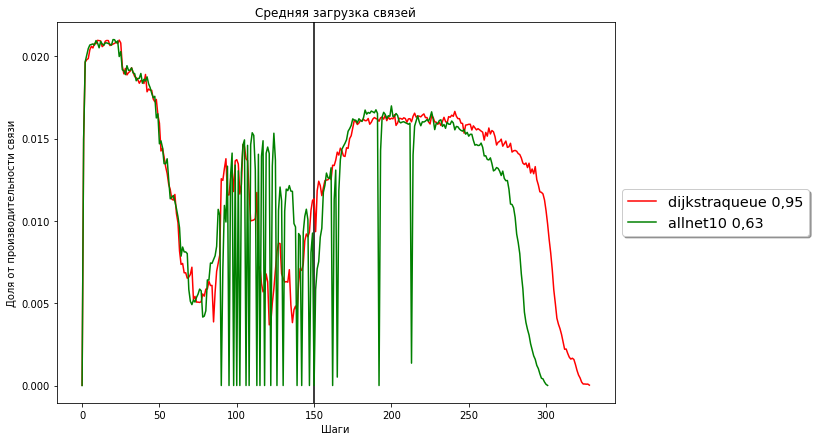

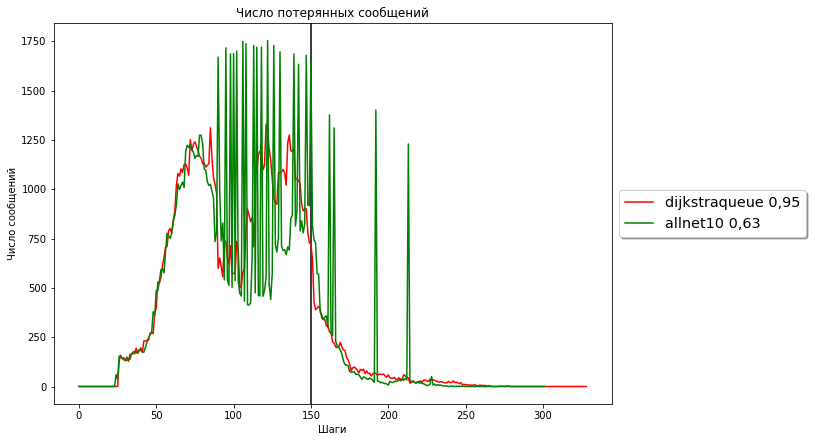

Доставлено 39997 Потеряно 73.3355% -dijkstraqueue 0,95
Доставлено 35500 Потеряно 76.3335% -allnet10 0,63


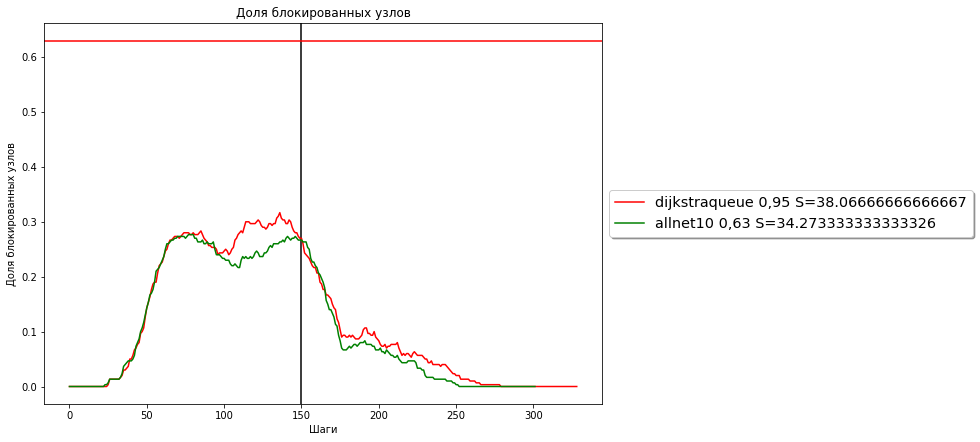

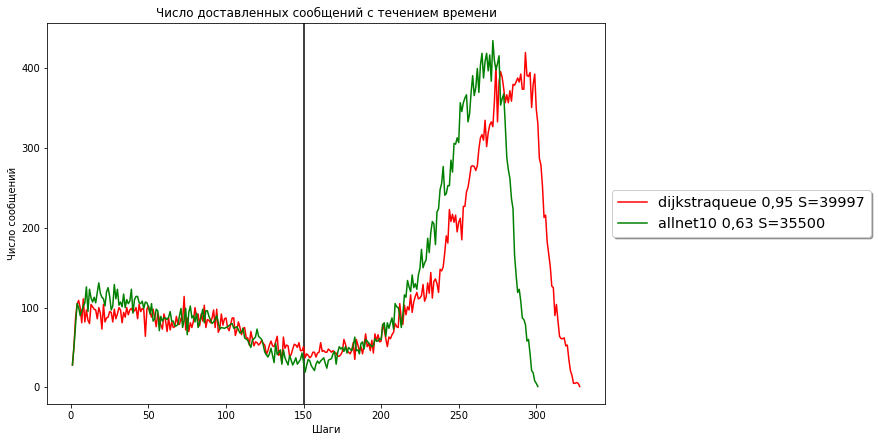

In [5]:
quantity = 1000;
log_tags = [
{"tag":  "7f0aa554-5deb-4585-a3db-d622c0027578", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "ee1e66d1-ba7f-4505-ab6c-fff4693aebca", "label": "allnet10 0,63", "color": "green"},
]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

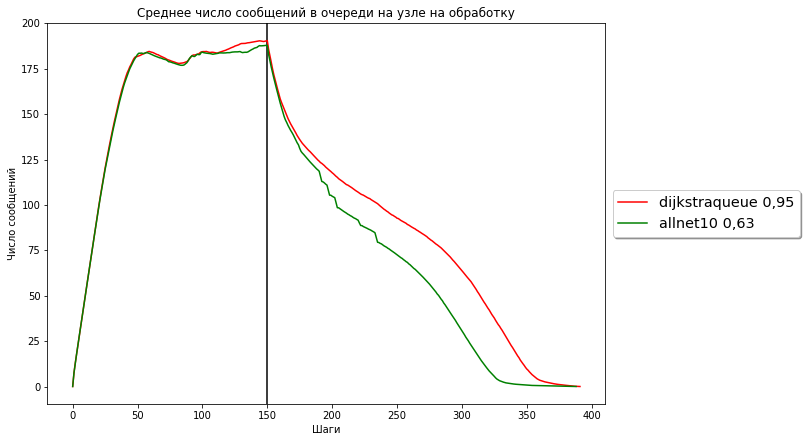

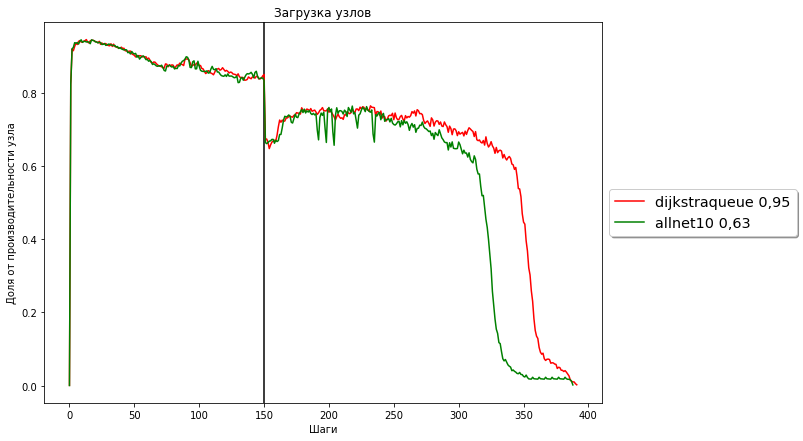

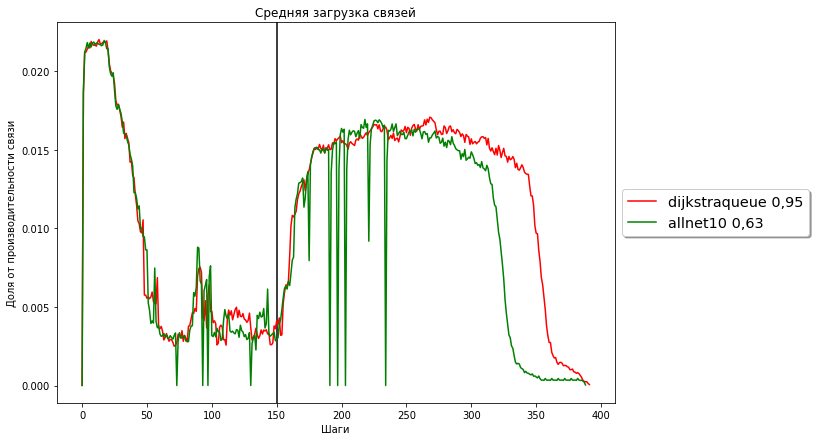

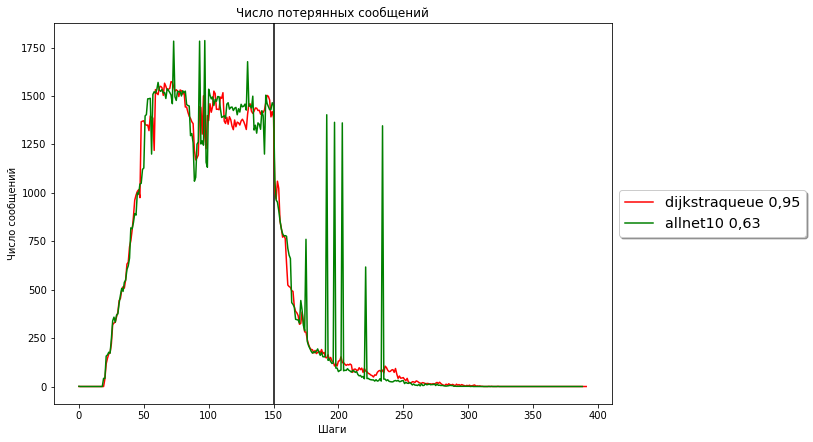

Доставлено 39822 Потеряно 82.3014% -dijkstraqueue 0,95
Доставлено 35032 Потеряно 84.4303% -allnet10 0,63


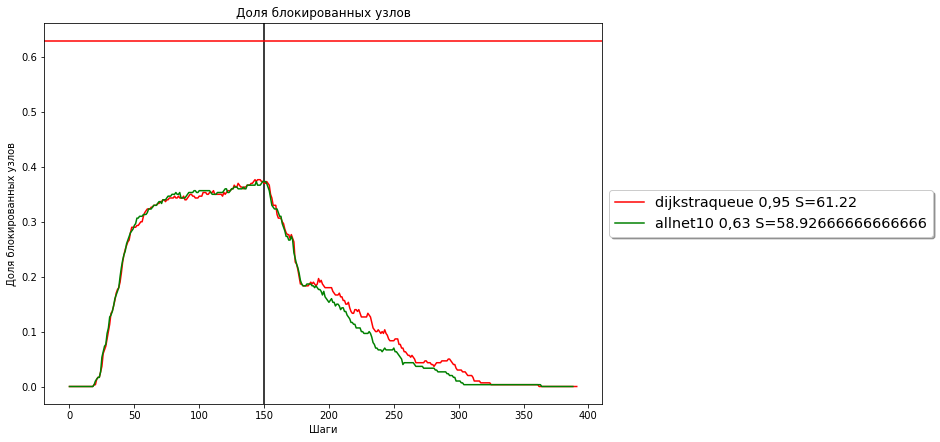

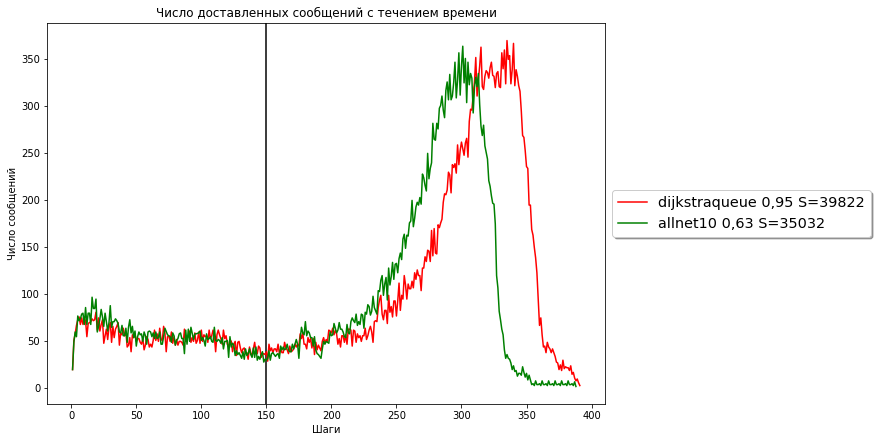

In [6]:
quantity = 1500;
log_tags = [
{"tag":  "ef3d22a7-46cc-4db1-873b-568f8ac207ea", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "322744b5-4449-4394-954d-f3f6e9b9ff63", "label": "allnet10 0,63", "color": "green"},
]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 44000 Потеряно 2.2244% -dijkstraqueue 0,95
Доставлено 44060 Потеряно 2.0911% -allnet10 0,63


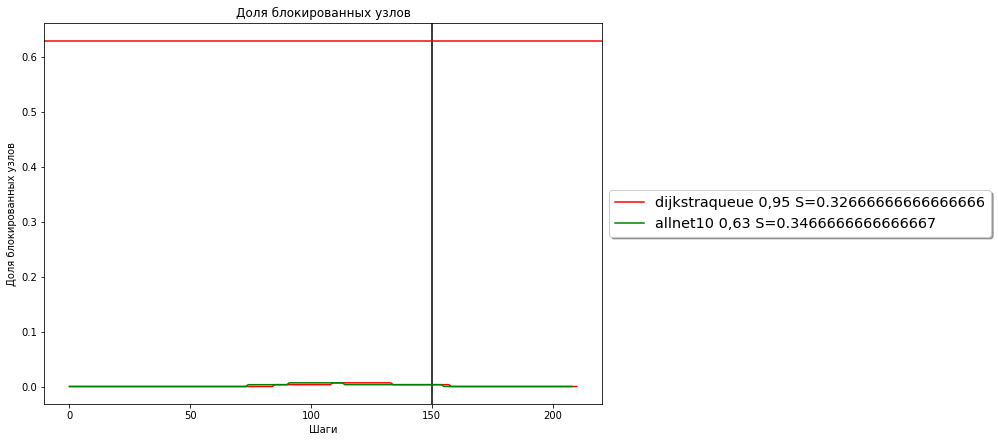

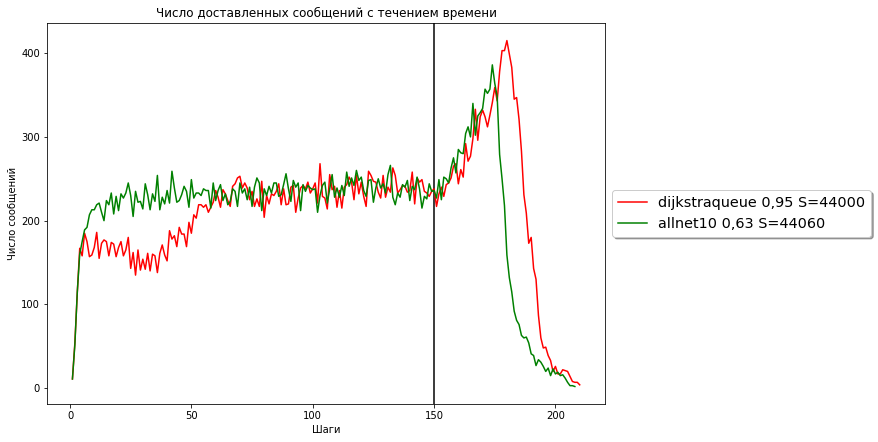

Доставлено 45640 Потеряно 56.5337% -dijkstraqueue 0,95
Доставлено 41787 Потеряно 60.2032% -allnet10 0,63


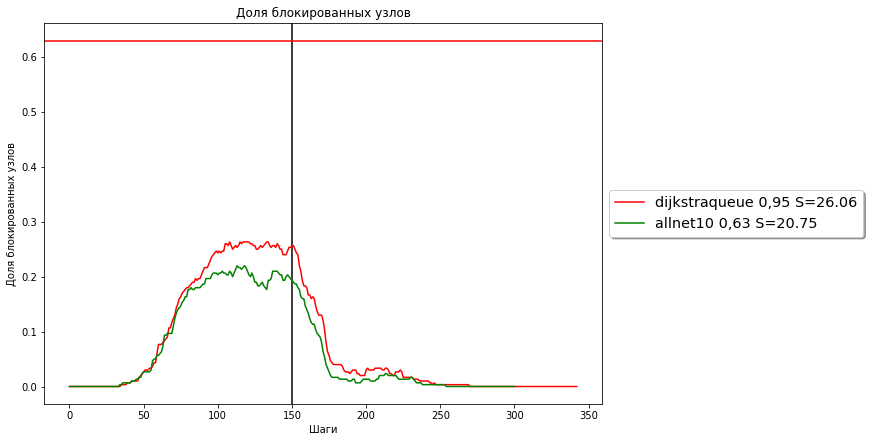

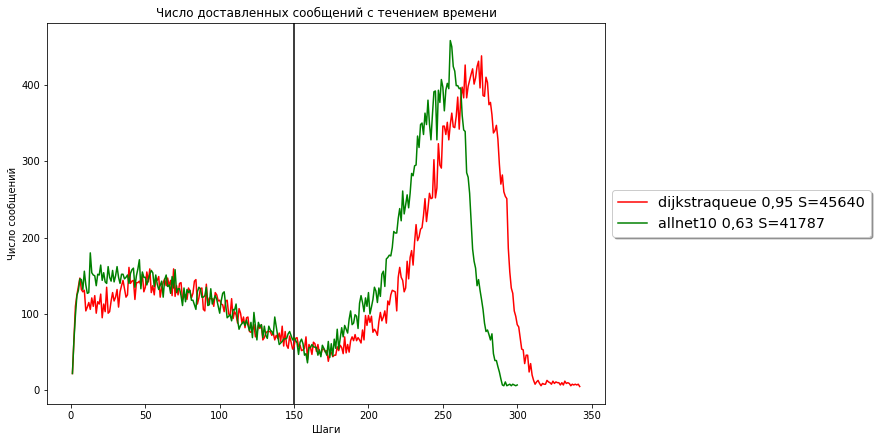

Доставлено 41736 Потеряно 69.0847% -dijkstraqueue 0,95
Доставлено 36313 Потеряно 73.1017% -allnet10 0,63


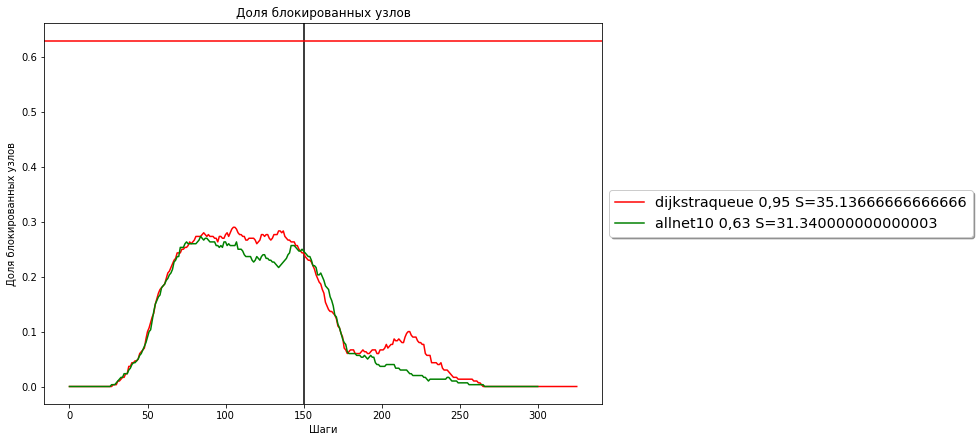

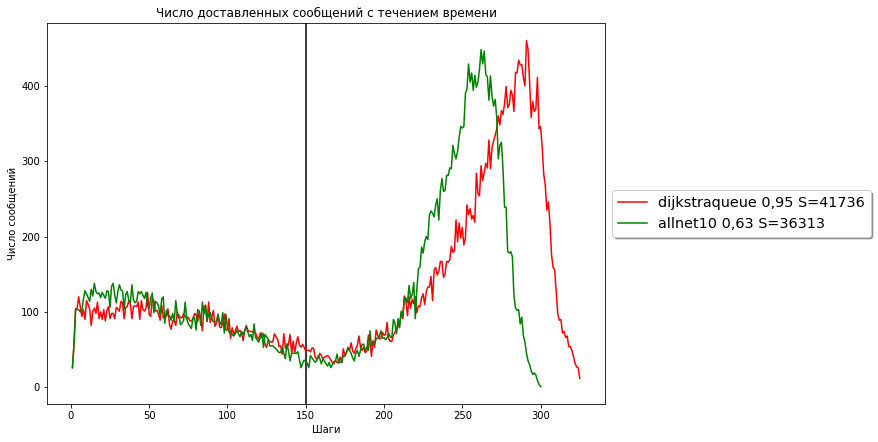

Доставлено 40181 Потеряно 79.3945% -dijkstraqueue 0,95
Доставлено 34928 Потеряно 82.0883% -allnet10 0,63


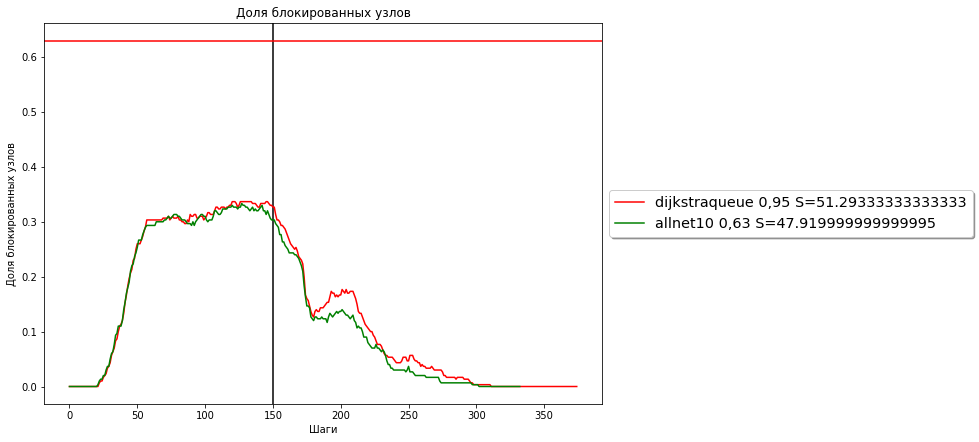

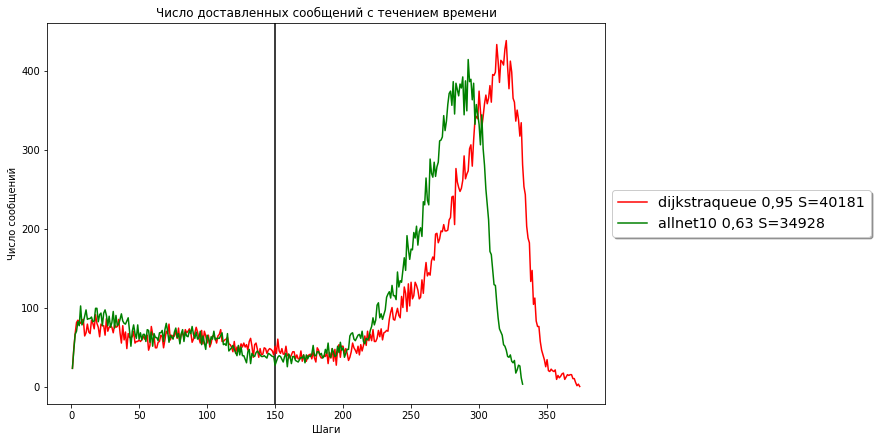

In [7]:
quantity = 300;
log_tags = [
{"tag":  "6ec61132-f1ab-4d13-9b7a-7591a51c4a80", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "2e1d5021-15cc-4c65-b493-315fae3ae43c", "label": "allnet10 0,63", "color": "green"},
]
showStatBlocked();
showStatMessage();

quantity = 700;
log_tags = [
{"tag":  "b907843e-f1c0-418d-8da2-dcfa39b63175", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "61f18c88-597d-4642-aff0-1425172f2063", "label": "allnet10 0,63", "color": "green"},
]
showStatBlocked();
showStatMessage();

quantity = 900;
log_tags = [
{"tag":  "30db1782-0474-44a5-987f-90ddce899161", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "1a11ca63-9578-4bbf-bf17-129bf495273c", "label": "allnet10 0,63", "color": "green"},
]
showStatBlocked();
showStatMessage();

quantity = 1300;
log_tags = [
{"tag":  "a4a271f4-0c1d-4d68-b3f8-42abf6697552", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "29a767b6-50df-4171-87af-b0e07def858c", "label": "allnet10 0,63", "color": "green"},
]
showStatBlocked();
showStatMessage();

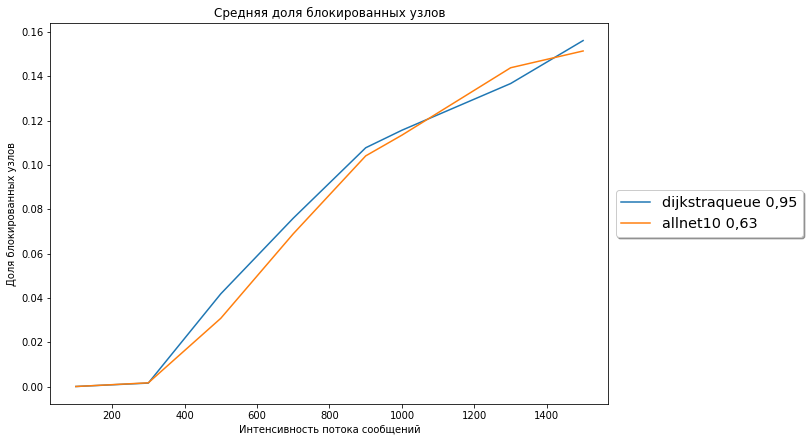

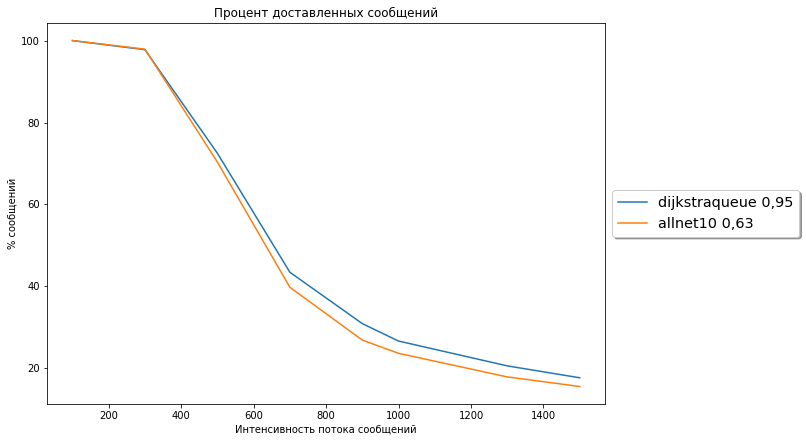

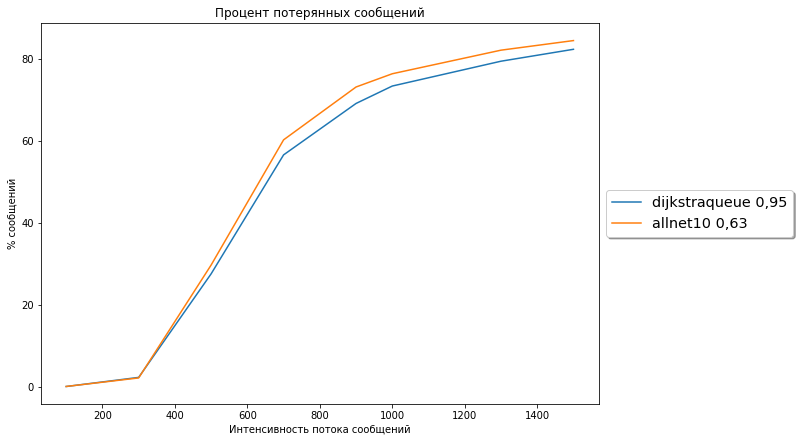

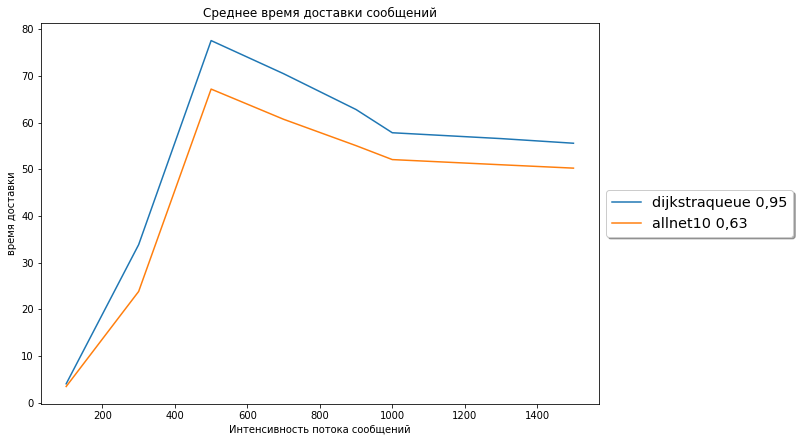

In [8]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()




In [9]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())


dijkstraqueue 0,95    0.079475
allnet10 0,63         0.076797

dijkstraqueue 0,95    48.796563
allnet10 0,63         50.987958

dijkstraqueue 0,95    52.366147
allnet10 0,63         45.467558
